In [138]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import rpy2.robjects as ro
from rpy2.robjects.packages import importr

In [139]:
base = importr('base')

This note book demonstrates various methods to measure correlations between data (numerical and categorical), both in Python and in R. 

(Still under heavy construction.)

# Make data

In [198]:
N = 200

## Numericals

In [199]:
some_numerical = np.random.uniform(0, 1, N)
some_numerical_with_noise = some_numerical + 0.1*np.random.randn(N)

some_numerical_r = ro.FloatVector(some_numerical)
some_numerical_with_noise_r = ro.FloatVector(some_numerical_with_noise)

## Categoricals

In [200]:
def generate_random_ints(num_categories, N):
    some_random_int = np.random.randint(0, num_categories, N)
    correlated_random_int = some_random_int.copy()
    
    for i in range(len(some_random_int)):
        if np.random.uniform(0, 1)>0.9:
            correlated_random_int[i]=np.random.randint(0, num_categories, 1)
    return some_random_int, correlated_random_int

In [201]:
some_random_int, correlated_random_int = generate_random_ints(3, N)

some_categorical_r = ro.FactorVector(some_random_int)
correlated_categorical_r = ro.FactorVector(correlated_random_int)

## Numerical v.s. categorical

In [202]:
numerical_correlated_to_some_categorical = np.array([np.random.normal(c, 1) for c in some_random_int])
numerical_correlated_to_some_categorical_r = ro.FloatVector(numerical_correlated_to_some_categorical)

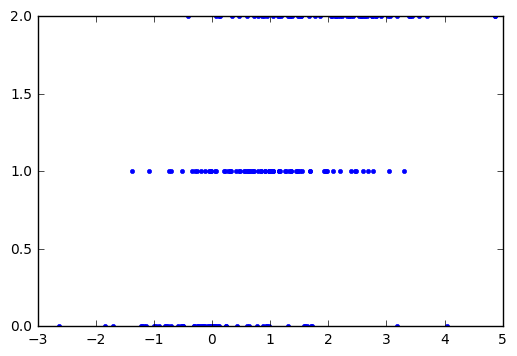

In [203]:
plt.plot(numerical_correlated_to_some_categorical, some_random_int, '.');

# Numerical v.s. numerical

## Pearson correlation coefficient

In [204]:
scipy.stats.pearsonr(some_numerical, some_numerical_with_noise)

(0.94234151208093209, 4.4491046472656076e-96)

In [205]:
print ro.r.cor(some_numerical_r, some_numerical_with_noise_r)

[1] 0.9423415



# Categorical v.s. categorical

## Chi-square

In [206]:
res = ro.r('chisq.test')(some_categorical_r, correlated_categorical_r)
res.names.r_repr()
print res[res.names.index('statistic')]
print res[res.names.index('p.value')]

'c("statistic", "parameter", "p.value", "method", "data.name", \n"observed", "expected", "residuals", "stdres")'

X-squared 
 324.4725 

[1] 5.682192e-69



# Numerical v.s. categorical

## t-test

### Python

#### Correlated

In [208]:
numerical_correlated_to_some_categorical_0 = numerical_correlated_to_some_categorical[np.where(some_random_int==0)]
numerical_correlated_to_some_categorical_1 = numerical_correlated_to_some_categorical[np.where(some_random_int==1)]
scipy.stats.ttest_ind(numerical_correlated_to_some_categorical_0, 
                      numerical_correlated_to_some_categorical_1, 
                      axis=0, equal_var=True)

Ttest_indResult(statistic=-4.8372631947516052, pvalue=3.6353225432322292e-06)

#### Uncorrelated

In [209]:
some_numerical_with_noise_0=some_numerical_with_noise[np.where(some_random_int==0)]
some_numerical_with_noise_1=some_numerical_with_noise[np.where(some_random_int==1)]
scipy.stats.ttest_ind(some_numerical_with_noise_0, 
                      some_numerical_with_noise_1,
                      axis=0, equal_var=True)

Ttest_indResult(statistic=0.20768078580814722, pvalue=0.83580073387585363)

### R

#### Correlated

In [210]:
numerical_correlated_to_some_categorical_0_r = ro.FloatVector(numerical_correlated_to_some_categorical_0)
numerical_correlated_to_some_categorical_1_r = ro.FloatVector(numerical_correlated_to_some_categorical_1)
res = ro.r('t.test')(numerical_correlated_to_some_categorical_0_r, 
                     numerical_correlated_to_some_categorical_1_r)
res.names.r_repr()
print res[res.names.index('statistic')]
print res[res.names.index('p.value')]

'c("statistic", "parameter", "p.value", "conf.int", "estimate", \n"null.value", "alternative", "method", "data.name")'

        t 
-4.702122 

[1] 7.837209e-06



#### Uncorrelated

In [211]:
some_numerical_with_noise_0_r = ro.FloatVector(some_numerical_with_noise_0)
some_numerical_with_noise_1_r = ro.FloatVector(some_numerical_with_noise_1)
res = ro.r('t.test')(some_numerical_with_noise_0_r, 
                     some_numerical_with_noise_1_r)
res.names.r_repr()
print res[res.names.index('statistic')]
print res[res.names.index('p.value')]

'c("statistic", "parameter", "p.value", "conf.int", "estimate", \n"null.value", "alternative", "method", "data.name")'

        t 
0.2071409 

[1] 0.8362583



## Analysis of Variance

### Python

#### Correlated

In [221]:
numerical_correlated_to_some_categorical_values = []
for v in set(some_random_int):
    numerical_correlated_to_some_categorical_values.append(
        numerical_correlated_to_some_categorical[np.where(some_random_int==v)]
    )

In [223]:
scipy.stats.f_oneway(*numerical_correlated_to_some_categorical_values)

F_onewayResult(statistic=54.157493741514372, pvalue=1.8081443132438605e-19)

#### Uncorrelated

In [224]:
some_numerical_with_noise_values = []
for v in set(some_random_int):
    some_numerical_with_noise_values.append(
        some_numerical_with_noise[np.where(some_random_int==v)]
    )

In [225]:
scipy.stats.f_oneway(*some_numerical_with_noise_values)

F_onewayResult(statistic=0.18241266549370055, pvalue=0.83339799296097494)

### R

#### Correlated

In [214]:
df = ro.DataFrame({'num':numerical_correlated_to_some_categorical_r, 'cat': some_categorical_r})
aov_res = ro.r('aov')(ro.Formula('num~cat'), df)
print base.summary(aov_res)

             Df Sum Sq Mean Sq F value Pr(>F)    
cat           2  121.4   60.71   54.16 <2e-16 ***
Residuals   197  220.8    1.12                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



#### Uncorrelated

In [215]:
df = ro.DataFrame({'num':some_numerical_with_noise_r, 'cat': some_categorical_r})
aov_res = ro.r('aov')(ro.Formula('num~cat'), df)
print base.summary(aov_res)

             Df Sum Sq Mean Sq F value Pr(>F)
cat           2  0.034 0.01702   0.182  0.833
Residuals   197 18.386 0.09333               



References: 
- http://stats.stackexchange.com/questions/108007/correlations-with-categorical-variables
- http://www.ats.ucla.edu/stat/mult_pkg/whatstat/default.htm